# GEM ML Framework Demonstrator - Deforestation Detection
In these notebooks, we provide an in-depth example of how the GEM ML framework can be used for segmenting deforested areas using Sentinel-2 imagery as input and the [TMF dataset](https://forobs.jrc.ec.europa.eu/TMF/) as a reference.
The idea is to use a neural network (NN) model for the analysis.
Thanks to the flexibility of the GEM ML framework, we can easily substitute the model in the future by adjusting only the configuration file.
We will have a look at the following notebooks separately:
- 00_Configuration
- 01_DataAcquisition
- 02_DataNormalization
- 03_TrainingValidationTesting
- 04_Inference_Clouds

Authors: Michael Engel (m.engel@tum.de) and Joana Reuss (joana.reuss@tum.de)

-----------------------------------------------------------------------------------

# Training, Validation and Testing
In this notebook, we will train, validate and test the model of choice.

In [1]:
import datetime as dt
import os
import platform

import matplotlib.pyplot as plt
import natsort
import numpy as np
import torch


from tensorboard import notebook
from tensorboardX import SummaryWriter

from libs import AugmentME
from libs.ConfigME import Config, importME
from libs.Dataset_eolearn import Dataset_eolearn
from libs.QuantileScaler_eolearn import QuantileScaler_eolearn_tdigest
from utils.transforms import Torchify

from eolearn.core import EOPatch, FeatureType

print("Working Directory:", os.getcwd())

/home/michael/anaconda3/envs/eolearn_water/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Incorporating libs!
Incorporating tasks!
Incorporating utils!
Working Directory: /home/michael/Documents/GEM/TUM-Git/eo-learn-examples/GEM-ML/Example_DeforestationDetection
Environment: eolearn_water
Executable: /home/michael/anaconda3/envs/eolearn_water/bin/python


# Config
First, we load our configuration file which provides all information we need throughout the script and linuxify our paths (if you are working on a Windows machine) as the eo-learn filesystem manager does not support backslashes for now.

In [2]:
#%% load configuration file
config = Config.LOAD("config.dill")

#%% linuxify
config.linuxify()

# Data Preparation

## Dataloading
First, we need to get the paths for all samples within our training, validation and testing datasets, respectively.

In [3]:
#%% training samples
paths_train = [os.path.join(config["dir_train"],file).replace("\\","/") for file in os.listdir(config["dir_train"])]

#%% validation samples
paths_validation = [os.path.join(config["dir_validation"],file).replace("\\","/") for file in os.listdir(config["dir_validation"])]

#%% testing samples
paths_test = [os.path.join(config["dir_test"],file).replace("\\","/") for file in os.listdir(config["dir_test"])]

### Quantile Scaler
As discussed in the third notebook, we want to apply quantile scaling to our data.
We load the scaler, we've already defined in the previous notebook.

In [4]:
Scaler = QuantileScaler_eolearn_tdigest.LOAD(os.path.join(config["dir_results"],config["savename_scaler"]))

Now, we are ready to define our datasets using the `Dataset_eolearn`!
Remember that PyTorch asks for shape `[batch_size x channels x timestamps x height x width]`.
The `QuantileScaler_eolearn_tdigest` handles this by setting `transform=Torchify(1)`.
For the reference and the mask, we use the `Torchify` class provided within the `Dataset_eolearn` module.

In [5]:
#%% training dataset
dataset_train = Dataset_eolearn(
    paths = paths_train,
    feature_data = (FeatureType.DATA,"data"),
    feature_reference = (FeatureType.MASK_TIMELESS,"reference"),
    feature_mask = (FeatureType.MASK_TIMELESS,"mask_reference"),

    transform_data = Scaler,
    transform_reference = Torchify(1),
    transform_mask = Torchify(1),
    
    return_idx = True,
    return_path = False,

    torchdevice = None,
    torchtype_data = torch.FloatTensor,
    torchtype_reference = torch.LongTensor,
    torchtype_mask = torch.LongTensor,
)

#%% validation dataset
dataset_validation = Dataset_eolearn(
    paths = paths_validation,
    feature_data = (FeatureType.DATA,"data"),
    feature_reference = (FeatureType.MASK_TIMELESS,"reference"),
    feature_mask = (FeatureType.MASK_TIMELESS,"mask_reference"),

    transform_data = Scaler,
    transform_reference = Torchify(1),
    transform_mask = Torchify(1),
    
    return_idx = True,
    return_path = False,

    torchdevice = None,
    torchtype_data = torch.FloatTensor,
    torchtype_reference = torch.LongTensor,
    torchtype_mask = torch.LongTensor,
)

#%% testing dataset
dataset_test = Dataset_eolearn(
    paths = paths_test,
    feature_data = (FeatureType.DATA,"data"),
    feature_reference = (FeatureType.MASK_TIMELESS,"reference"),
    feature_mask = (FeatureType.MASK_TIMELESS,"mask_reference"),

    transform_data = Scaler,
    transform_reference = Torchify(1),
    transform_mask = Torchify(1),
    
    return_idx = True,
    return_path = False,

    torchdevice = None,
    torchtype_data = torch.FloatTensor,
    torchtype_reference = torch.LongTensor,
    torchtype_mask = torch.LongTensor,
)

Let's test our datasets!

In [6]:
sample_train = dataset_train[:config["batch_size"]]
print('Training Data Shape:',sample_train[0].shape)
print('Training Reference Shape:',sample_train[1].shape)
print('Training Mask Shape:',sample_train[2].shape)
print()

sample_validation = dataset_validation[:config["max_batch_size"]]
print('Validation Data Shape:',sample_validation[0].shape)
print('Validation Reference Shape:',sample_validation[1].shape)
print('Validation Mask Shape:',sample_validation[2].shape)
print()

sample_test = dataset_test[:config["max_batch_size"]]
print('Testing Data Shape:',sample_test[0].shape)
print('Testing Reference Shape:',sample_test[1].shape)
print('Testing Mask Shape:',sample_test[2].shape)
print()

Training Data Shape: torch.Size([12, 6, 256, 256])
Training Reference Shape: torch.Size([12, 256, 256])
Training Mask Shape: torch.Size([12, 256, 256])

Validation Data Shape: torch.Size([2, 6, 256, 256])
Validation Reference Shape: torch.Size([2, 256, 256])
Validation Mask Shape: torch.Size([2, 256, 256])

Testing Data Shape: torch.Size([2, 6, 256, 256])
Testing Reference Shape: torch.Size([2, 256, 256])
Testing Mask Shape: torch.Size([2, 256, 256])



Let's define our dataloader for each dataset.
We will double our `batch_size` for validation and testing as no gradient calculation is needed here.

In [7]:
#%% training dataloader
dataloader_train = torch.utils.data.DataLoader(
    dataset = dataset_train,
    batch_size = config["batch_size"],
    shuffle = True,
    sampler = None,
    batch_sampler = None,
    num_workers = 0 if platform.system()=="Windows" else config["threads"],
    collate_fn = None,
    pin_memory = False,
    drop_last = True,
    timeout = 0,
    worker_init_fn = None,
    multiprocessing_context = None,
    generator = None
)

#%% validation dataloader
dataloader_validation = torch.utils.data.DataLoader(
    dataset = dataset_validation,
    batch_size = config["max_batch_size"]*2,
    shuffle = False,
    sampler = None,
    batch_sampler = None,
    num_workers = 0 if platform.system()=="Windows" else config["threads"],
    collate_fn = None,
    pin_memory = False,
    drop_last = True,
    timeout = 0,
    worker_init_fn = None,
    multiprocessing_context = None,
    generator = None
)

#%% testing dataloader
dataloader_test = torch.utils.data.DataLoader(
    dataset = dataset_test,
    batch_size = config["max_batch_size"]*2,
    shuffle = False,
    sampler = None,
    batch_sampler = None,
    num_workers = 0 if platform.system()=="Windows" else config["threads"],
    collate_fn = None,
    pin_memory = False,
    drop_last = True,
    timeout = 0,
    worker_init_fn = None,
    multiprocessing_context = None,
    generator = None
)

# Model
It is time to initialize our model.
To do so, we use the `importME` method. It allows us to stay flexible regarding the chosen model architecture and easily adapt it in the future.

In [8]:
#%% import model
module_model = importME(config["module_model"])

#%% initialize model
model = module_model(**config["kwargs_model"])

We want to augment the model such that it fits in our training pipeline.
We will add the following functionalities:
- IO methods: __saving__ and __loading__
- Method to __access gradients during training__ which will be used for a monitoring "brainwaves"
- Method that counts the __number of model parameters__

The benefit of adding these methods becomes clear when thinking of changing the architecture used without intending to change the IO interface of your code.

In [9]:
#%% general IO
AugmentME.augment_IO(model,savekey='save',loadkey='load',mode='torch')

#%% checkpoint saving
AugmentME.augment_checkpoint(model,key='save_checkpoint',mode='torch')

#%% gradient method
AugmentME.augment_gradient(model,key='get_gradient',mode=None)

#%% number of parameters
AugmentME.augment_Ntheta(model,key="get_Ntheta")

True

As a test if the augmenting worked, we want to have a look at the number of parameters.

In [10]:
#%% number of parameters
print("Number of parameters:",model.get_Ntheta())

Number of parameters: 22447636


# Training pipeline

### Loss function
Before we can start training our model, we have to define a loss function.
We will keep it as flexible as the model itself and use `importME`.

In [11]:
loss_function = importME(config["module_loss"])(**config["kwargs_loss"])

### Optimizer
No optimization without an optimizer! 
Due to corresponding device issues, we have to send our model to the device before we define our optimizer.

In [12]:
#%% send model to device to avoid device errors
model.to(config["device"])

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

Now, we can define our optimizer with the model parameters already on our chosen device!

In [13]:
optimizer = importME(config["module_optimizer"])(model.parameters(),**config["kwargs_optimizer"])

To assess the performance of our model, we load some metric.

In [14]:
metric = importME(config["module_metric"])

### Experiment logger: Tensorboard
Of course, we would like to track the proceeding of our training procedure.
Hence, we define a tensorboard [SummaryWriter](https://tensorboardx.readthedocs.io/en/latest/tensorboard.html#tensorboardX.SummaryWriter).

In [15]:
writer = SummaryWriter(config["dir_tensorboard"])

The tensorboard SummaryWriter enables us to do some nice stuff.
For example, adding a graph of our model.

In [16]:
writer.add_graph(model, sample_train[0].to(config["device"]))

/home/michael/anaconda3/envs/eolearn_water/lib/python3.8/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


Furthermore, we would like to make our experiment reproducible.
Hence, we set the seeds such that all random number generation and shuffling is done in a deterministic manner.

In [17]:
#%% reproducibility
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In case of a premature exit of the training procedure, we insert a resume flag here.
It enables the user to start with the chosen checkpoint or automatically choose the most recent one.

In [18]:
#%% resume flag
resume = False

#%% resume case
if resume:
    if resume==True:
        resume = os.path.join(config["dir_checkpoints"],natsort.natsorted(os.listdir(config["dir_checkpoints"]))[-1])
    else:
        resume = resume
    
    print(f'Loading Checkpoint {resume}!')
    checkpoint = torch.load(resume,map_location=config["device"])
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    bestloss = checkpoint['bestloss']
    bestmetric = checkpoint["bestmetric"]
    epoch_ = checkpoint['epoch']+1
    logstep_ = checkpoint['logstep']
else:
    epoch_ = 0
    logstep_ = 0
    bestloss = np.inf
    bestmetric = 0 if type(metric) is not list and type(metric) is not np.ndarray else [0 for _ in range(len(metric))]

model.train()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

### Starting training!
Let's start the training loop!

In [19]:
#%% training loop
print('Start training...')
logstep = -1+logstep_
for epoch in range(config["n_epochs"]-epoch_):
    epoch = epoch+epoch_
    for step, (x, y, mask, idx) in enumerate(dataloader_train):
        print('epoch %i step %i'%(epoch,step))
        
        #%%% clean cache of GPU
        torch.cuda.empty_cache()

        #%%% compute logstep
        logstep = logstep+1

        #%%% zero gradients
        optimizer.zero_grad(set_to_none=True)
        
        #%%% determine number of minibatches
        if type(x)==list:
            batchcount = int(np.ceil(len(x[0])/config["max_batch_size"]))
        else:
            batchcount = int(np.ceil(len(x)/config["max_batch_size"]))

        out = []
        loss = 0
        #%%% minibatch-loop
        for p in range(batchcount):
            #%%%% determine indices
            lowidx = p*config["max_batch_size"]
            if p==batchcount-1:
                if type(x)==list:
                    highidx = len(x[0])
                else:
                    highidx = len(x)
            else:
                highidx = (p+1)*config["max_batch_size"]
                
            if type(x)==list:
                tmp_x = [torch.index_select(x_,dim=0,index=torch.arange(lowidx,highidx)).detach() for x_ in x]
            else:
                tmp_x = torch.index_select(x,dim=0,index=torch.arange(lowidx,highidx)).detach()
            
            tmp_y = torch.index_select(y,dim=0,index=torch.arange(lowidx,highidx)).detach()
            tmp_mask = torch.index_select(mask,dim=0,index=torch.arange(lowidx,highidx)).detach()
        
            #%%%% forward pass
            if type(tmp_x)==list:
                tmp_out = model.forward([item_.to(config["device"]) for item_ in tmp_x])
            else:
                tmp_out = model.forward(tmp_x.to(config["device"]))

            #%%%% compute loss
            tmp_loss = loss_function(tmp_out.softmax(1),tmp_y.squeeze(1).to(config["device"]))
            tmp_loss = (tmp_loss*tmp_mask.long().squeeze(1).to(config["device"])).sum() / (torch.count_nonzero(tmp_mask.long().to(config["device"])))

            #%%%% compute gradient
            tmp_loss.backward()
            
            #%%%% collect minibatch output
            out.append(tmp_out.detach().cpu())
            loss = loss+torch.count_nonzero(tmp_mask.long().detach().cpu())/torch.count_nonzero(mask.long().detach().cpu())*tmp_loss.detach().cpu()

            #%%%% free space # keep?
            del(tmp_x)
            del(tmp_y)
            del(tmp_mask)
            del(tmp_loss)
            del(tmp_out)

        #%%% update model parameters
        optimizer.step()
        
        #%%% compute metric
        out = torch.concat(out,dim=0)
        if type(metric)==list:
            train_acc = [metric_(out,y.cpu().detach(),mask.cpu().detach()) for metric_ in metric]
        else:
            train_acc = metric(out,y.cpu().detach(),mask.cpu().detach())

        #%%% printing stuff
        print(
            "[{}] Training Step: {:d}/{:d} {:d}.{:d}, \tbatch_size: {} \tLoss: {:.4f} \tAcc: {}".format(
                dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                logstep+1,
                len(dataloader_train)*config["n_epochs"],
                epoch,
                step,
                config["batch_size"],
                loss.mean(),
                {metric_.__name__:train_acc_ for metric_,train_acc_ in zip(metric,train_acc)} if type(metric)==list else train_acc
            )
        )

        #%%% write to tensorboard
        #%%%% log loss
        writer.add_scalar(f'LossTraining/{type(loss_function).__name__}', loss, global_step=logstep)
        
        #%%%% log metric
        if type(metric)==list:
            writer.add_scalars('AccuracyTraining',{metric_.__name__:train_acc_ for metric_,train_acc_ in zip(metric,train_acc)},global_step=logstep)
        else:
            writer.add_scalar('AccuracyTraining', train_acc, global_step=logstep)
        
        #%%%% gradients
        writer.add_histogram('GradientsTraining/AllParams', model.get_gradient(mode='vec',index=None), global_step=logstep, bins=50, walltime=None, max_bins=100)
        for name,grad in model.get_gradient(mode='named params',device="cpu",detach=True):
            writer.add_histogram(f'NamedGradientsTraining/{name}', grad, global_step=logstep, bins=50, walltime=None, max_bins=100)
        
    #%%% intermediate evaluation of validation set
    if config["eval_freq"] and (epoch+1)%config["eval_freq"]==0:
        print()
        model.eval()
        loss_val = []
        acc_val = []
        weights_val = []
        with torch.no_grad():
            fig, axis = plt.subplots(nrows=len(dataloader_validation)*2, ncols=dataloader_validation.batch_size, figsize=(3*dataloader_validation.batch_size,2*3*len(dataloader_validation)))
            fig.suptitle('Validation Data %i'%logstep)                
            for step_validation, (x_validation, y_validation, mask_validation, idx_validation) in enumerate(dataloader_validation):
                print('validation step %i'%(step_validation))

                #%%%% clean cache of GPU
                torch.cuda.empty_cache()

                #%%%% forward pass
                if type(x)==list:
                    out_validation = model.forward([item_.to(config["device"]) for item_ in x_validation])
                else:
                    out_validation = model.forward(x_validation.to(config["device"]))

                #%%%% compute loss
                loss_validation = loss_function(out_validation.softmax(1),y_validation.squeeze(1).to(config["device"]))
                loss_validation = (loss_validation*mask_validation.long().squeeze(1).to(config["device"])).sum() / (torch.count_nonzero(mask_validation.long().to(config["device"])))

                #%%%% compute metric
                if type(metric)==list:
                    validation_acc = [metric_(out_validation.cpu().detach(),y_validation.cpu().detach(),mask_validation.cpu().detach()) for metric_ in metric]
                else:
                    validation_acc = metric(out_validation.cpu().detach(),y_validation.cpu().detach(),mask_validation.cpu().detach())

                #%%%% printing stuff
                print(
                    "[{}] Validation Step: {:d}/{:d}, \tbatch_size: {} \tLoss: {:.4f} \tAcc: {}".format(
                        dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                        step_validation+1,
                        len(dataloader_validation),
                        dataloader_validation.batch_size,
                        loss_validation.mean(),
                        {metric_.__name__:validation_acc_ for metric_,validation_acc_ in zip(metric,validation_acc)} if type(metric)==list else validation_acc
                    )
                )
                
                #%%%% collect predictions
                predictions_validation = torch.argmax(out_validation,1).cpu().detach().numpy()
                
                axis[step_validation*2][0].set_ylabel("Prediction")
                axis[step_validation*2+1][0].set_ylabel("Reference")
                for i in range(dataloader_validation.batch_size):
                    axis[step_validation*2][i].imshow(predictions_validation[i].squeeze(),cmap=config["cmap_reference"],vmin=0,vmax=config["num_classes"])
                    axis[step_validation*2][i].set_xticks([])
                    axis[step_validation*2][i].set_yticks([])
                    
                    axis[step_validation*2+1][i].imshow(y_validation.cpu().detach().numpy()[i].squeeze(),cmap=config["cmap_reference"],vmin=0,vmax=config["num_classes"])
                    axis[step_validation*2+1][i].set_xticks([])
                    axis[step_validation*2+1][i].set_yticks([])
                    
                #%%%% collect loss and accuracy
                loss_val.append(loss_validation.cpu().detach().numpy())
                acc_val.append(validation_acc)
                weights_val.append(torch.count_nonzero(mask_validation).cpu().detach().numpy())

            #%%%% total loss and accuracy
            total = np.sum([np.sum(weight_) for weight_ in weights_val])
            loss_val_total = np.sum([weight_/total*loss_ for weight_,loss_ in zip(weights_val,loss_val)])
            if type(metric)==list:
                acc_val_total = [np.sum([weight_/total*acc_[i] for weight_,acc_ in zip(weights_val,acc_val)]) for i in range(len(metric))]
            else:
                acc_val_total = np.sum([weight_/total*acc_ for weight_,acc_ in zip(weights_val,acc_val)])
            
            # print total values
            print(
                "[{}] Validation: \tTotal Loss: {:.4f} \tTotal Acc: {}".format(
                    dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                    loss_val_total,
                    {metric_.__name__:validation_acc_ for metric_,validation_acc_ in zip(metric,acc_val_total)} if type(metric)==list else acc_val_total
                )
            )

            #%%%% write to tensorboard
            #%%%%% log loss
            writer.add_scalar(f'LossValidation/{type(loss_function).__name__}', loss_val_total, global_step=logstep)

            #%%%%% log metric
            if type(metric)==list:
                writer.add_scalars('AccuracyValidation',{metric_.__name__:validation_acc_ for metric_,validation_acc_ in zip(metric,acc_val_total)},global_step=logstep)
            else:
                writer.add_scalar('AccuracyValidation', acc_val_total, global_step=logstep)
            
            #%%%%% log figure
            plt.tight_layout()
            plt.savefig(fname=os.path.join(config["dir_imgs_validation"],"PredictionValidation_%i"%logstep), dpi="figure")
            writer.add_figure(tag="PredictionValidation", figure=fig, global_step=logstep, close=True, walltime=None)

        model.train()
        print()
        
        #%%% checkpoint for best validation loss
        if config["checkpoint_bestloss"] and bestloss>loss_val_total:
            bestloss = loss_val_total
            print("New best validation loss! Storing checkpoint and model!")
            model.save_checkpoint(
                savename = os.path.join(config["dir_checkpoints"],'checkpoint_bestloss.tar'),
                epoch = epoch,
                logstep = logstep,
                optimizer_state_dict = optimizer.state_dict(),
                loss = loss,
                bestloss = bestloss,
                bestmetric = acc_val_total # reasonable if someone would like to restart training from that checkpoint
            )
            model.save(savename=os.path.join(config["dir_results"],config["model_savename_inference_bestloss"]),mode='inference')
            model.save(savename=os.path.join(config["dir_results"],config["model_savename_bestloss"]),mode='entirely')
            
        #%%% checkpoint for best validation metric(s)
        if config["checkpoint_bestmetric"]:
            if type(metric)==list:
                for m_, (metric_,validation_acc_) in enumerate(zip(metric,acc_val_total)):
                    if bestmetric[m_]<validation_acc_:
                        bestmetric[m_] = validation_acc_
                        print(f"New best validation metric {metric_.__name__}! Storing checkpoint and model!")
                        model.save_checkpoint(
                            savename = os.path.join(config["dir_checkpoints"],f'checkpoint_bestmetric_{metric_.__name__}.tar'),
                            epoch = epoch,
                            logstep = logstep,
                            optimizer_state_dict = optimizer.state_dict(),
                            loss = loss,
                            bestloss = loss_val_total, # reasonable if someone would like to restart training from that checkpoint
                            bestmetric = bestmetric
                        )
                        model.save(savename=os.path.join(config["dir_results"],config["model_savename_inference_bestmetric"]+f"_{metric_.__name__}"),mode='inference')
                        model.save(savename=os.path.join(config["dir_results"],config["model_savename_bestmetric"]+f"_{metric_.__name__}"),mode='entirely')
            else:
                if bestmetric<validation_acc_:
                    bestmetric = acc_val_total
                    print(f"New best validation metric! Storing checkpoint and model!")
                    model.save_checkpoint(
                        savename = os.path.join(config["dir_checkpoints"],'checkpoint_bestmetric.tar'),
                        epoch = epoch,
                        logstep = logstep,
                        optimizer_state_dict = optimizer.state_dict(),
                        loss = loss,
                        bestloss = loss_val_total, # reasonable if someone would like to restart training from that checkpoint
                        bestmetric = bestmetric
                    )
                    model.save(savename=os.path.join(config["dir_results"],config["model_savename_inference_bestmetric"]),mode='inference')
                    model.save(savename=os.path.join(config["dir_results"],config["model_savename_bestmetric"]),mode='entirely')

    #%%% checkpoint
    if config["checkpoint_freq"] and (epoch+1)%config["checkpoint_freq"]==0:
        model.save_checkpoint(
            savename = os.path.join(config["dir_checkpoints"],f'checkpoint_{logstep}_{epoch}_{step}.tar'),
            epoch = epoch,
            logstep = logstep,
            optimizer_state_dict = optimizer.state_dict(),
            loss = loss,
            bestloss = loss_val_total
        )

#%% save model
print('saving final checkpoint!')
model.save_checkpoint(savename=os.path.join(config["dir_checkpoints"],f'checkpoint_{logstep}_{epoch}_{step}.tar'), epoch=epoch, logstep=logstep, optimizer_state_dict=optimizer.state_dict(), loss=loss)
print('saving inference model')
model.save(savename=os.path.join(config["dir_results"],config["model_savename_inference"]),mode='inference')
print('saving entire model')
model.save(savename=os.path.join(config["dir_results"],config["model_savename"]),mode='entirely')

Start training...
epoch 0 step 0
[2023-02-13T15-29-50] Training Step: 1/192 0.0, 	batch_size: 12 	Loss: 1.3909 	Acc: {'accuracy': tensor(0.2314), 'cohen_kappa': -0.05557622815866159}
epoch 0 step 1
[2023-02-13T15-29-52] Training Step: 2/192 0.1, 	batch_size: 12 	Loss: 1.2519 	Acc: {'accuracy': tensor(0.5437), 'cohen_kappa': 0.2546997744812055}
epoch 0 step 2
[2023-02-13T15-29-54] Training Step: 3/192 0.2, 	batch_size: 12 	Loss: 1.3069 	Acc: {'accuracy': tensor(0.4159), 'cohen_kappa': 0.08775329156226808}
epoch 1 step 0
[2023-02-13T15-29-56] Training Step: 4/192 1.0, 	batch_size: 12 	Loss: 1.2904 	Acc: {'accuracy': tensor(0.4400), 'cohen_kappa': 0.12432958128214222}
epoch 1 step 1
[2023-02-13T15-29-58] Training Step: 5/192 1.1, 	batch_size: 12 	Loss: 1.1497 	Acc: {'accuracy': tensor(0.5859), 'cohen_kappa': 0.3175880981314283}
epoch 1 step 2
[2023-02-13T15-29-59] Training Step: 6/192 1.2, 	batch_size: 12 	Loss: 1.0248 	Acc: {'accuracy': tensor(0.7305), 'cohen_kappa': 0.48029103065277545}


saveME_checkpoint: start saving checkpoint!
saveME_checkpoint: saved
epoch 8 step 0
[2023-02-13T15-30-46] Training Step: 25/192 8.0, 	batch_size: 12 	Loss: 1.0354 	Acc: {'accuracy': tensor(0.7091), 'cohen_kappa': 0.5514917751169328}
epoch 8 step 1
[2023-02-13T15-30-47] Training Step: 26/192 8.1, 	batch_size: 12 	Loss: 0.9314 	Acc: {'accuracy': tensor(0.8112), 'cohen_kappa': 0.6780455239697434}
epoch 8 step 2
[2023-02-13T15-30-49] Training Step: 27/192 8.2, 	batch_size: 12 	Loss: 1.0057 	Acc: {'accuracy': tensor(0.7384), 'cohen_kappa': 0.5964450949672223}
epoch 9 step 0
[2023-02-13T15-30-51] Training Step: 28/192 9.0, 	batch_size: 12 	Loss: 1.0137 	Acc: {'accuracy': tensor(0.7309), 'cohen_kappa': 0.5903812894133914}
epoch 9 step 1
[2023-02-13T15-30-52] Training Step: 29/192 9.1, 	batch_size: 12 	Loss: 0.9804 	Acc: {'accuracy': tensor(0.7617), 'cohen_kappa': 0.6213388239819887}
epoch 9 step 2
[2023-02-13T15-30-54] Training Step: 30/192 9.2, 	batch_size: 12 	Loss: 0.9575 	Acc: {'accuracy

epoch 16 step 0
[2023-02-13T15-31-40] Training Step: 49/192 16.0, 	batch_size: 12 	Loss: 0.9072 	Acc: {'accuracy': tensor(0.8365), 'cohen_kappa': 0.7411572348413954}
epoch 16 step 1
[2023-02-13T15-31-42] Training Step: 50/192 16.1, 	batch_size: 12 	Loss: 0.9061 	Acc: {'accuracy': tensor(0.8384), 'cohen_kappa': 0.7408152261223787}
epoch 16 step 2
[2023-02-13T15-31-43] Training Step: 51/192 16.2, 	batch_size: 12 	Loss: 0.9671 	Acc: {'accuracy': tensor(0.7763), 'cohen_kappa': 0.6324787150886226}
epoch 17 step 0
[2023-02-13T15-31-46] Training Step: 52/192 17.0, 	batch_size: 12 	Loss: 0.9449 	Acc: {'accuracy': tensor(0.7960), 'cohen_kappa': 0.6890508872487974}
epoch 17 step 1
[2023-02-13T15-31-48] Training Step: 53/192 17.1, 	batch_size: 12 	Loss: 0.9047 	Acc: {'accuracy': tensor(0.8385), 'cohen_kappa': 0.7474719785004946}
epoch 17 step 2
[2023-02-13T15-31-49] Training Step: 54/192 17.2, 	batch_size: 12 	Loss: 0.9182 	Acc: {'accuracy': tensor(0.8299), 'cohen_kappa': 0.7080361702570148}

val

epoch 24 step 2
[2023-02-13T15-32-41] Training Step: 75/192 24.2, 	batch_size: 12 	Loss: 0.9105 	Acc: {'accuracy': tensor(0.8322), 'cohen_kappa': 0.7330999673571206}
epoch 25 step 0
[2023-02-13T15-32-43] Training Step: 76/192 25.0, 	batch_size: 12 	Loss: 0.9072 	Acc: {'accuracy': tensor(0.8354), 'cohen_kappa': 0.7411250430168612}
epoch 25 step 1
[2023-02-13T15-32-45] Training Step: 77/192 25.1, 	batch_size: 12 	Loss: 0.8860 	Acc: {'accuracy': tensor(0.8598), 'cohen_kappa': 0.7832929728974216}
epoch 25 step 2
[2023-02-13T15-32-46] Training Step: 78/192 25.2, 	batch_size: 12 	Loss: 0.9418 	Acc: {'accuracy': tensor(0.7981), 'cohen_kappa': 0.6709183786183947}

validation step 0
[2023-02-13T15-32-48] Validation Step: 1/2, 	batch_size: 4 	Loss: 0.8908 	Acc: {'accuracy': tensor(0.8615), 'cohen_kappa': 0.76976191160364}
validation step 1
[2023-02-13T15-32-48] Validation Step: 2/2, 	batch_size: 4 	Loss: 0.9800 	Acc: {'accuracy': tensor(0.7633), 'cohen_kappa': 0.5884229627519881}
[2023-02-13T15-


epoch 36 step 0
[2023-02-13T15-33-51] Training Step: 109/192 36.0, 	batch_size: 12 	Loss: 0.9108 	Acc: {'accuracy': tensor(0.8335), 'cohen_kappa': 0.7143996699382182}
epoch 36 step 1
[2023-02-13T15-33-53] Training Step: 110/192 36.1, 	batch_size: 12 	Loss: 0.8524 	Acc: {'accuracy': tensor(0.8917), 'cohen_kappa': 0.8236461660906257}
epoch 36 step 2
[2023-02-13T15-33-55] Training Step: 111/192 36.2, 	batch_size: 12 	Loss: 0.9022 	Acc: {'accuracy': tensor(0.8407), 'cohen_kappa': 0.7625193022972058}
epoch 37 step 0
[2023-02-13T15-33-57] Training Step: 112/192 37.0, 	batch_size: 12 	Loss: 0.8693 	Acc: {'accuracy': tensor(0.8730), 'cohen_kappa': 0.7984373620851993}
epoch 37 step 1
[2023-02-13T15-33-58] Training Step: 113/192 37.1, 	batch_size: 12 	Loss: 0.9493 	Acc: {'accuracy': tensor(0.7913), 'cohen_kappa': 0.6620778111068322}
epoch 37 step 2
[2023-02-13T15-34-00] Training Step: 114/192 37.2, 	batch_size: 12 	Loss: 0.9051 	Acc: {'accuracy': tensor(0.8407), 'cohen_kappa': 0.751104493099796

[2023-02-13T15-34-56] Validation: 	Total Loss: 1.0001 	Total Acc: {'accuracy': 0.75236475, 'cohen_kappa': 0.5244144115648464}

epoch 46 step 0
[2023-02-13T15-34-57] Training Step: 139/192 46.0, 	batch_size: 12 	Loss: 0.9026 	Acc: {'accuracy': tensor(0.8409), 'cohen_kappa': 0.7551895802651266}
epoch 46 step 1
[2023-02-13T15-34-59] Training Step: 140/192 46.1, 	batch_size: 12 	Loss: 0.8764 	Acc: {'accuracy': tensor(0.8650), 'cohen_kappa': 0.7838902443764181}
epoch 46 step 2
[2023-02-13T15-35-00] Training Step: 141/192 46.2, 	batch_size: 12 	Loss: 0.8826 	Acc: {'accuracy': tensor(0.8599), 'cohen_kappa': 0.7807473826717046}
epoch 47 step 0
[2023-02-13T15-35-03] Training Step: 142/192 47.0, 	batch_size: 12 	Loss: 0.9044 	Acc: {'accuracy': tensor(0.8397), 'cohen_kappa': 0.7383520624233151}
epoch 47 step 1
[2023-02-13T15-35-04] Training Step: 143/192 47.1, 	batch_size: 12 	Loss: 0.8909 	Acc: {'accuracy': tensor(0.8530), 'cohen_kappa': 0.7766442827616414}
epoch 47 step 2
[2023-02-13T15-35-06] 

[2023-02-13T15-36-05] Training Step: 173/192 57.1, 	batch_size: 12 	Loss: 0.8785 	Acc: {'accuracy': tensor(0.8634), 'cohen_kappa': 0.77522015666332}
epoch 57 step 2
[2023-02-13T15-36-07] Training Step: 174/192 57.2, 	batch_size: 12 	Loss: 0.8602 	Acc: {'accuracy': tensor(0.8817), 'cohen_kappa': 0.8217523507343993}

validation step 0
[2023-02-13T15-36-08] Validation Step: 1/2, 	batch_size: 4 	Loss: 0.8616 	Acc: {'accuracy': tensor(0.8823), 'cohen_kappa': 0.7992412217989857}
validation step 1
[2023-02-13T15-36-08] Validation Step: 2/2, 	batch_size: 4 	Loss: 0.9498 	Acc: {'accuracy': tensor(0.7905), 'cohen_kappa': 0.564126666085013}
[2023-02-13T15-36-09] Validation: 	Total Loss: 0.9028 	Total Acc: {'accuracy': 0.8393599, 'cohen_kappa': 0.6892994105029768}

epoch 58 step 0
[2023-02-13T15-36-10] Training Step: 175/192 58.0, 	batch_size: 12 	Loss: 0.8533 	Acc: {'accuracy': tensor(0.8897), 'cohen_kappa': 0.833603056308877}
epoch 58 step 1
[2023-02-13T15-36-12] Training Step: 176/192 58.1, 	ba

True

# Testing
After the long training, we would like to test our model on the chosen test tiles.

We load the model providing the __best validation loss__ using the `BaseClass` from AugmentME.

In [20]:
model = AugmentME.BaseClass(mode="torch")
model.load(os.path.join(config["dir_results"],config["model_savename_bestloss"]))

loadME_torch: start loading of the entire model!
loadME_torch: loaded


True

Since the testing script is rather similar to the validation part of our training procedure, we do not discuss this here.

Start testing...
Test step 0
[2023-02-13T15-44-07] Test Step: 1/2, 	batch_size: 4 	Loss: 0.9858 	Acc: {'accuracy': tensor(0.7514), 'cohen_kappa': 0.5258390902529031}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


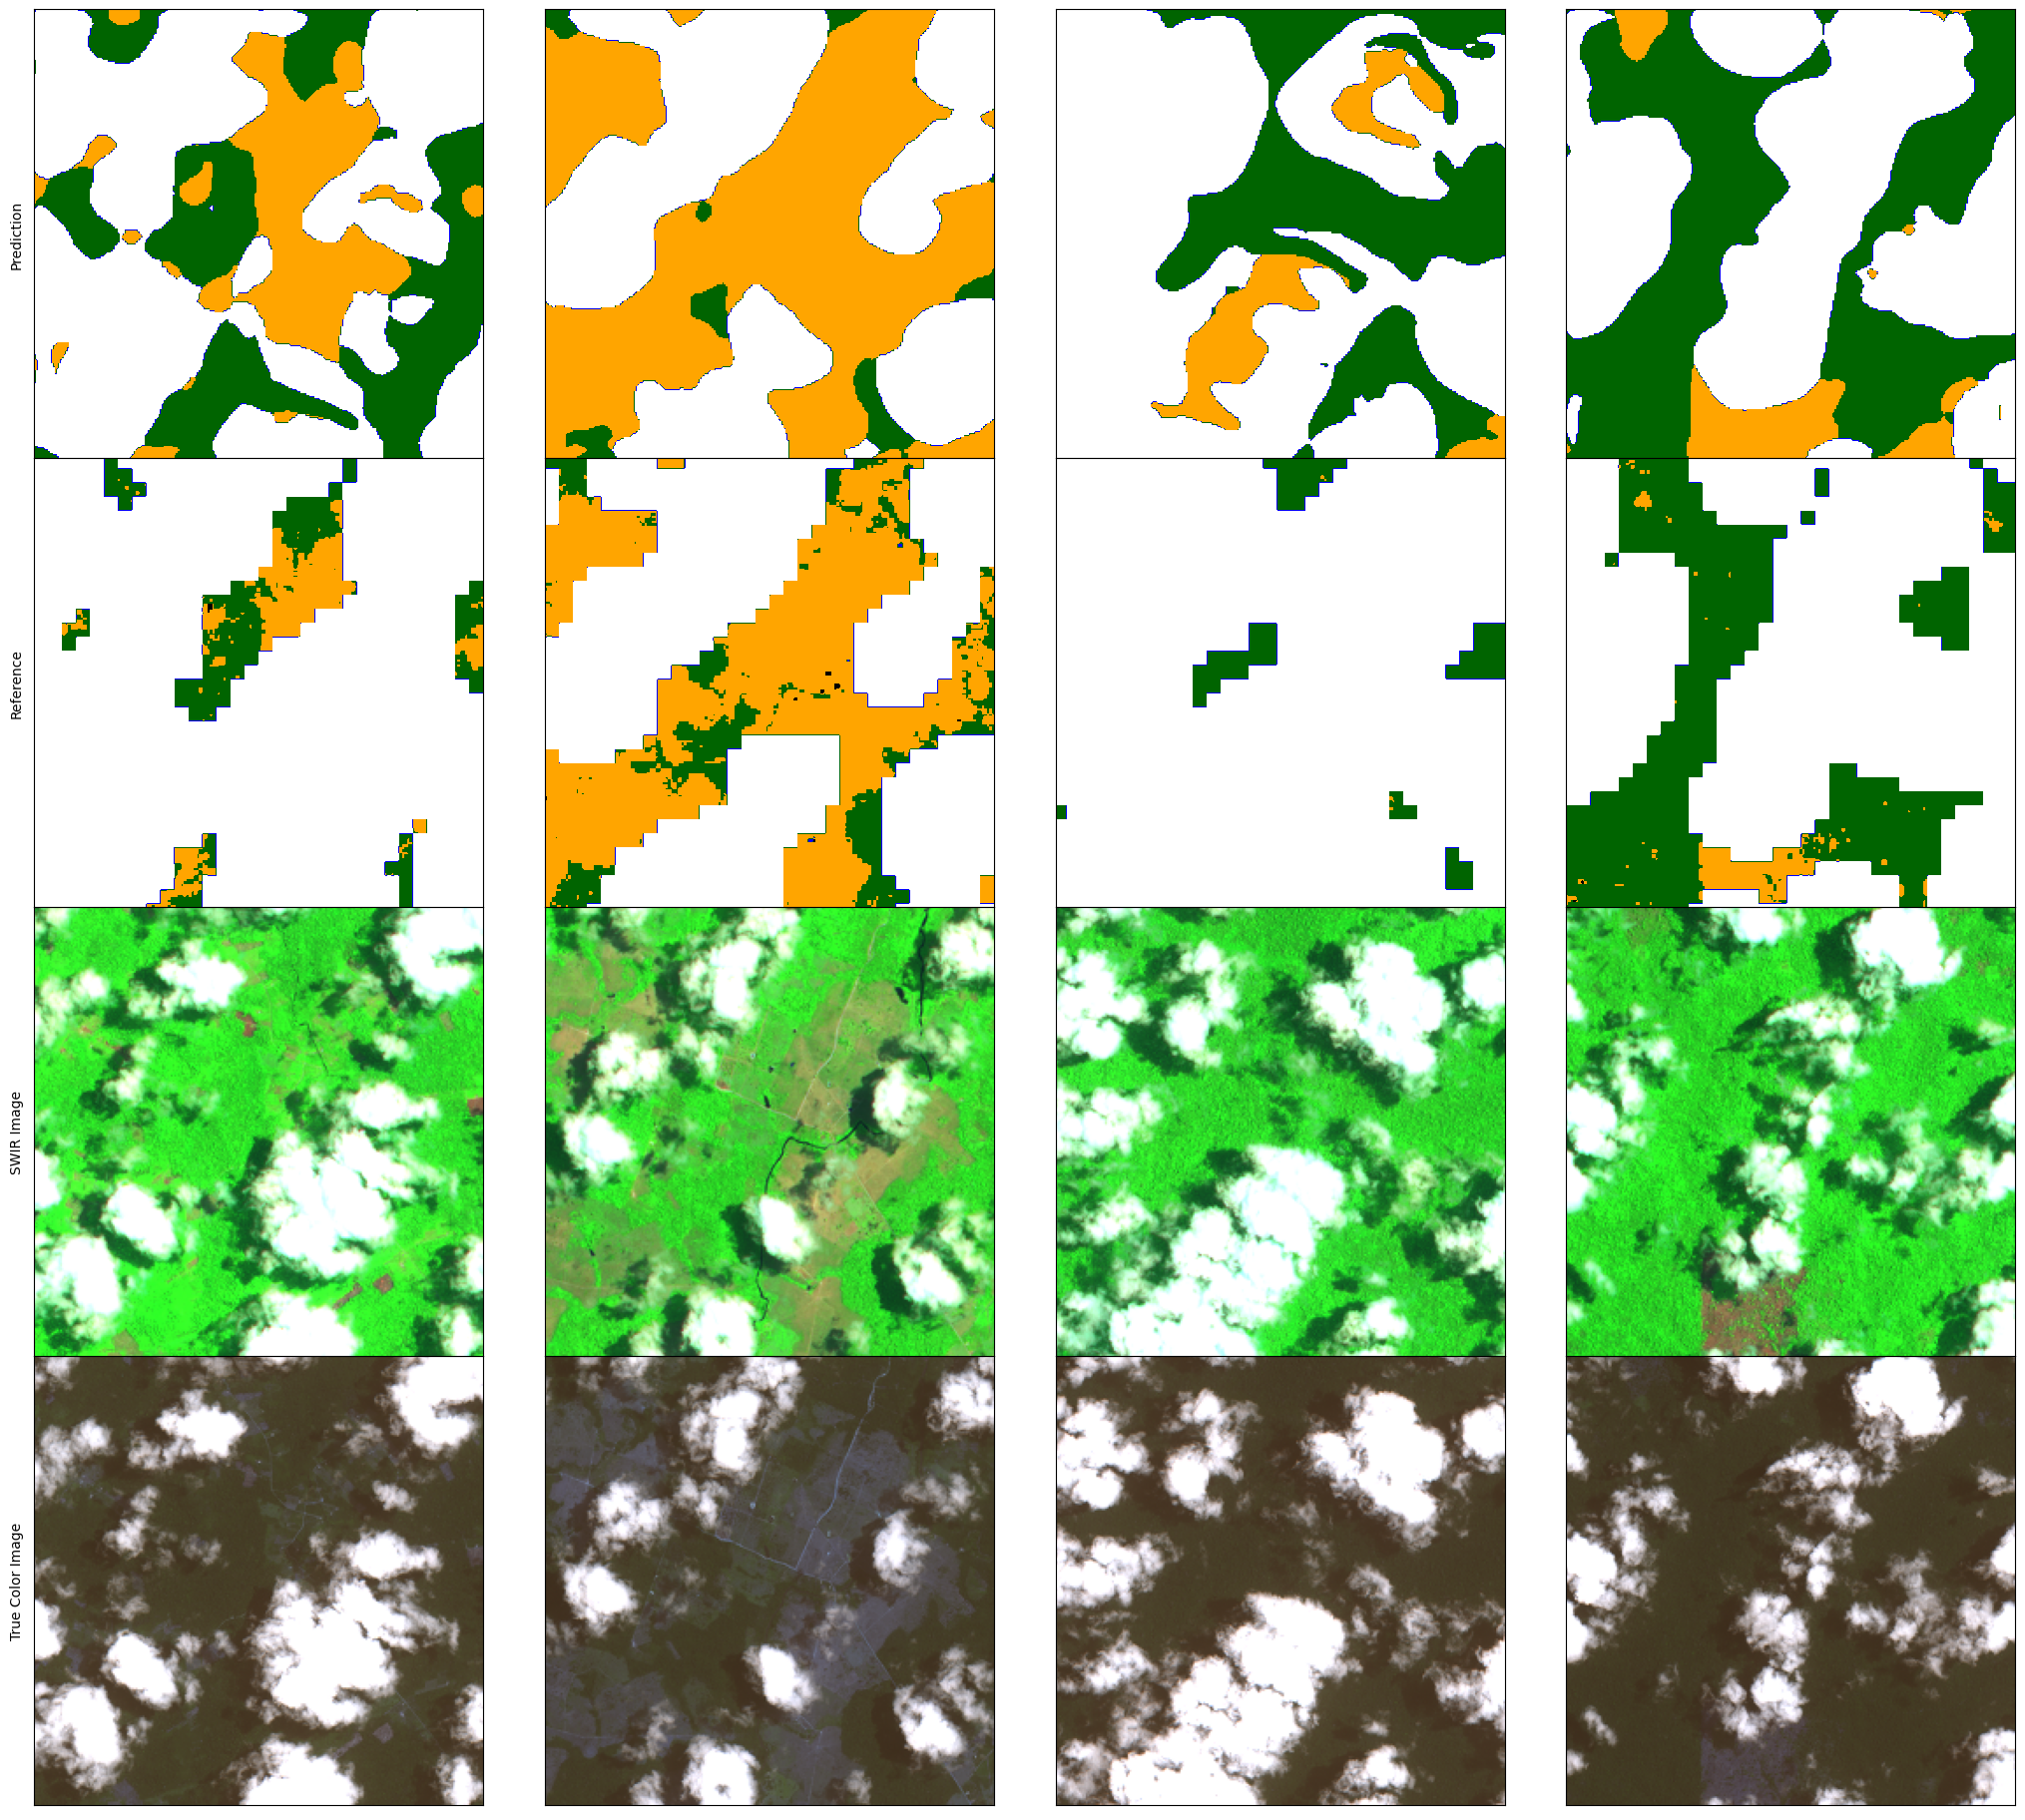

Test step 1
[2023-02-13T15-44-09] Test Step: 2/2, 	batch_size: 4 	Loss: 0.9805 	Acc: {'accuracy': tensor(0.7578), 'cohen_kappa': 0.6144480004861541}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


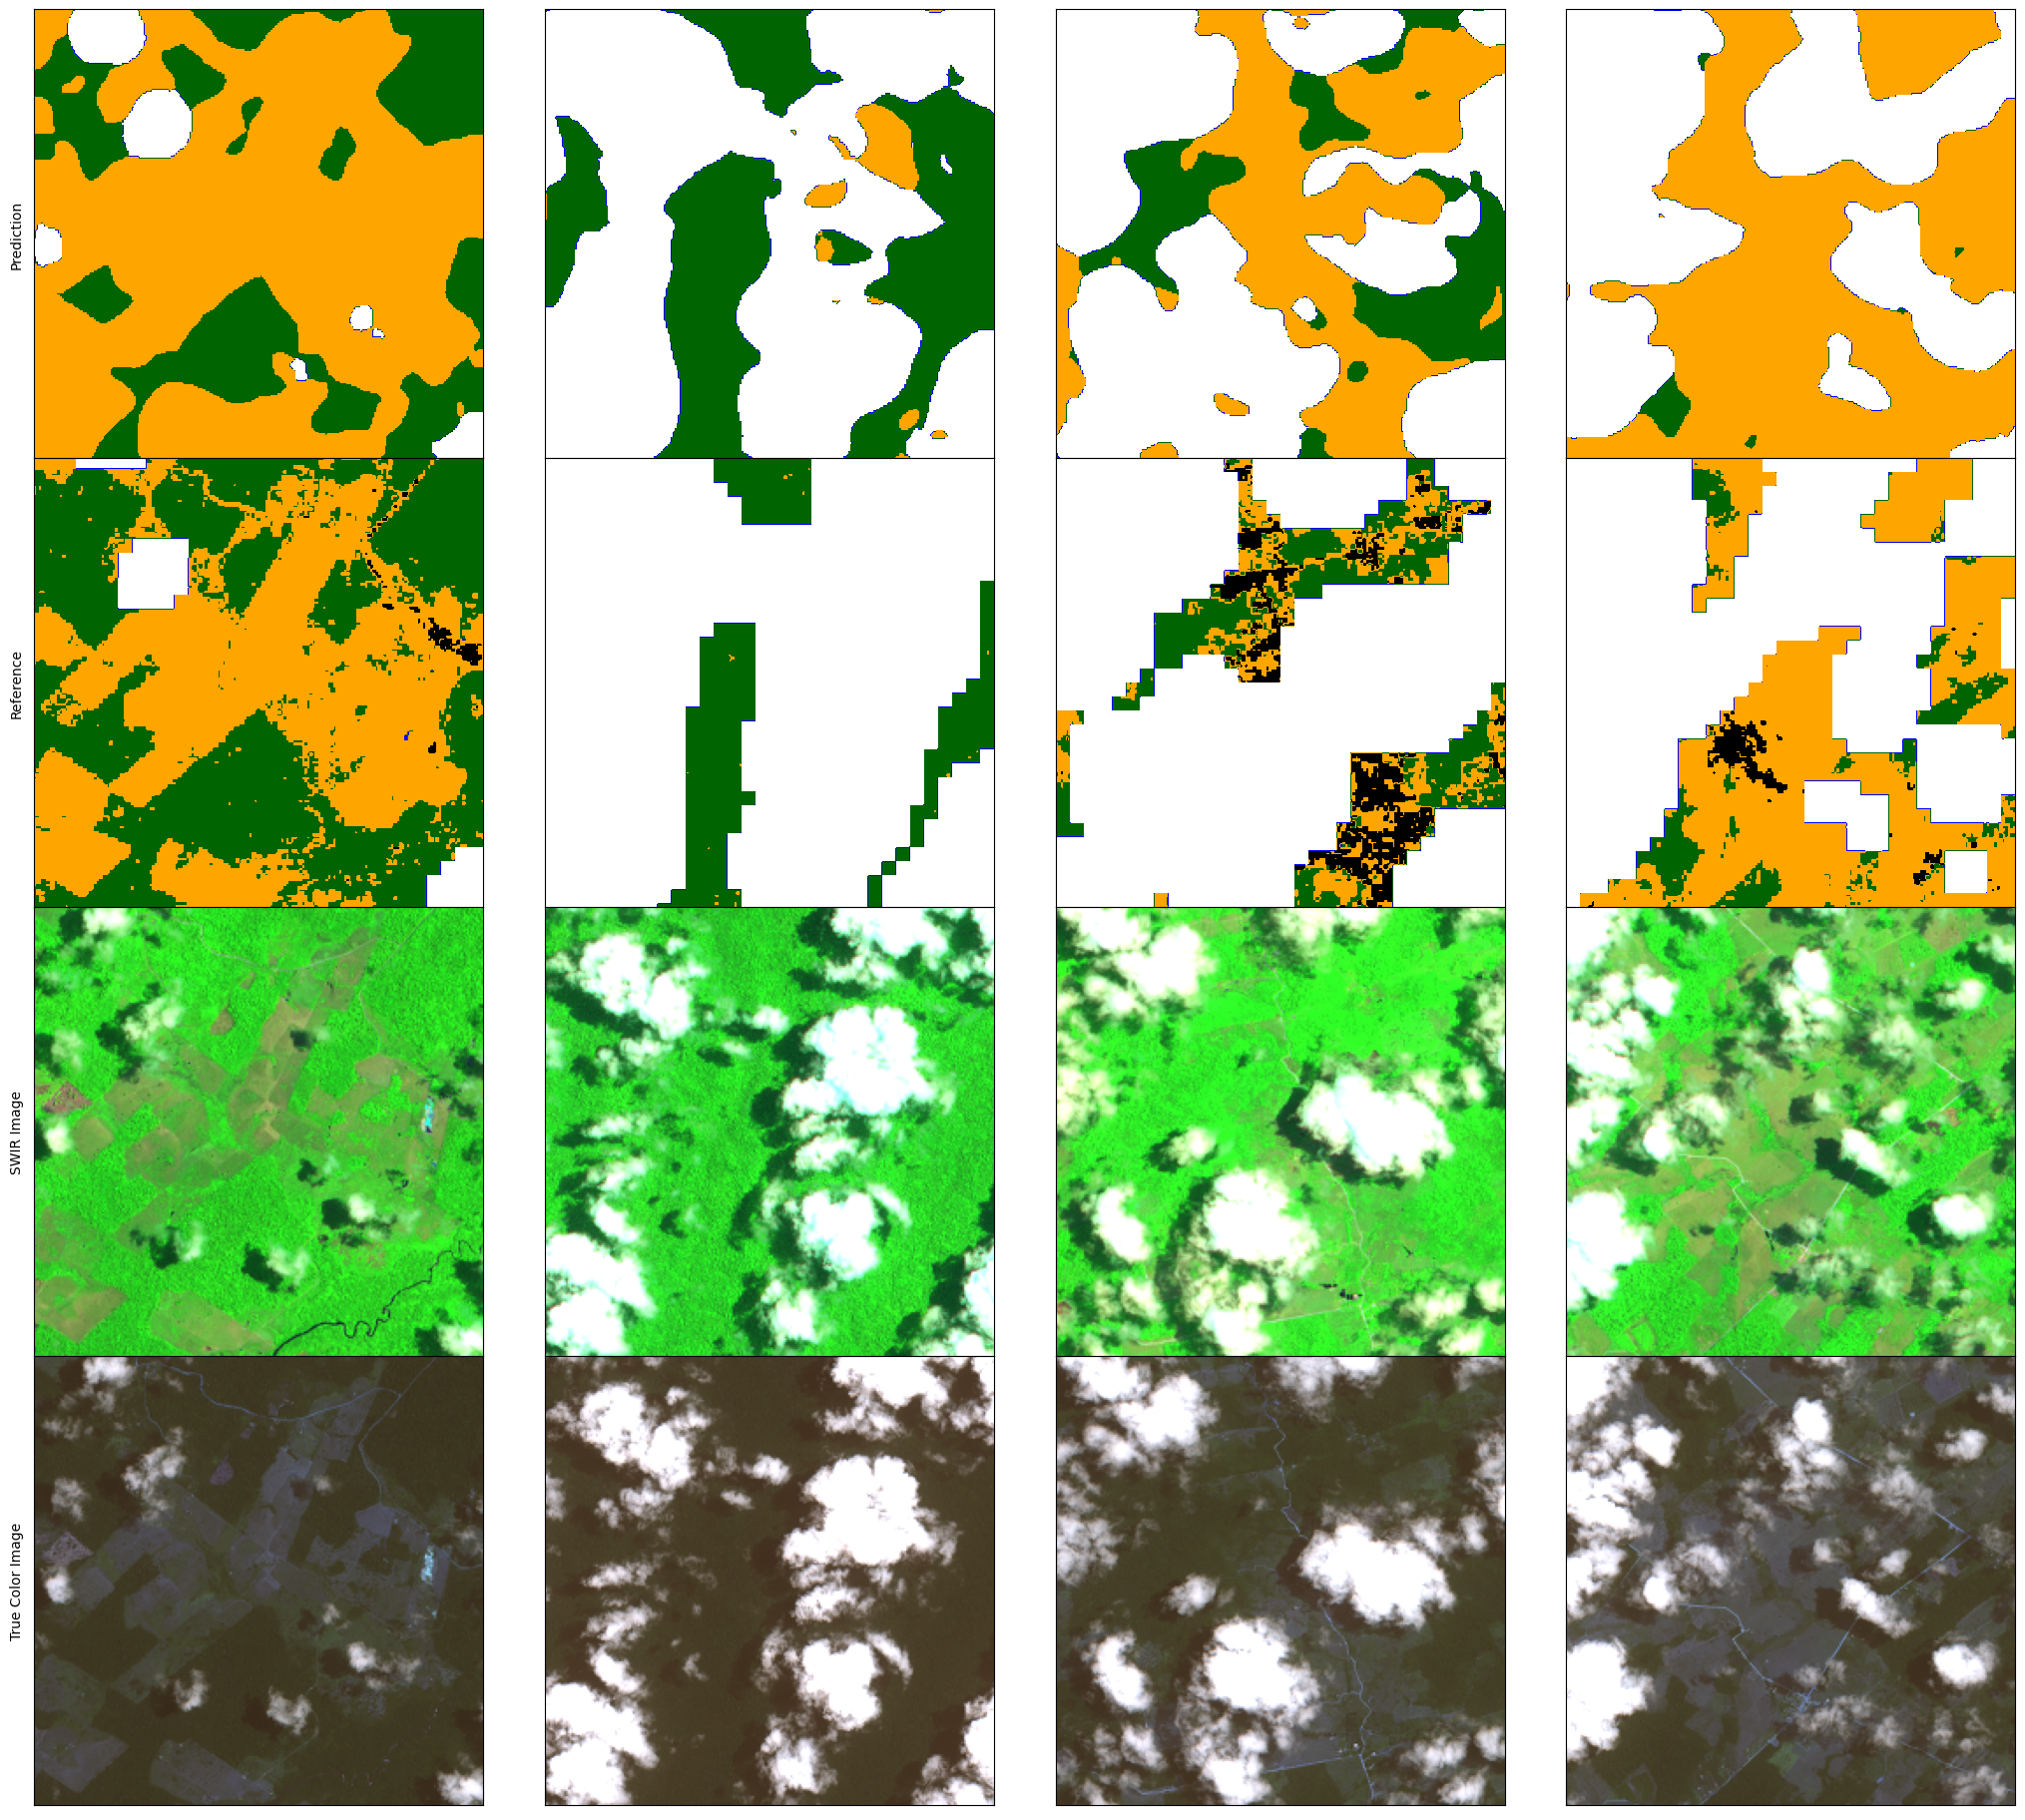

[2023-02-13T15-44-11] Test: 	Total Loss: 0.9832 	Total Acc: {'accuracy': 0.754561, 'cohen_kappa': 0.5697383328759842}



In [30]:
#%% testing loop
print('Start testing...')
model.eval()
losss_test = []
accs_test = []
weights_test = []
with torch.no_grad():              
    for step_test, (x_test, y_test, mask_test, idx_test) in enumerate(dataloader_test):
        print('Test step %i'%(step_test))

        #%%%% clean cache of GPU
        torch.cuda.empty_cache()

        #%%%% forward pass
        if type(x_test)==list:
            out_test = model.forward([item_.to(config["device"]) for item_ in x_test])
        else:
            out_test = model.forward(x_test.to(config["device"]))

        #%%%% compute loss
        loss_test = loss_function(out_test.softmax(1),y_test.squeeze(1).to(config["device"]))
        loss_test = (loss_test*mask_test.long().squeeze(1).to(config["device"])).sum() / (torch.count_nonzero(mask_test.long().to(config["device"])))

        #%%%% compute metric
        if type(metric)==list:
            test_acc = [metric_(out_test.cpu().detach(),y_test.cpu().detach(),mask_test.cpu().detach()) for metric_ in metric]
        else:
            test_acc = metric(out_test.cpu().detach(),y_test.cpu().detach(),mask_test.cpu().detach())

        #%%%% printing stuff
        print(
            "[{}] Test Step: {:d}/{:d}, \tbatch_size: {} \tLoss: {:.4f} \tAcc: {}".format(
                dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
                step_test+1,
                len(dataloader_test),
                dataloader_test.batch_size,
                loss_test.mean(),
                {metric_.__name__:test_acc_ for metric_,test_acc_ in zip(metric,test_acc)} if type(metric)==list else test_acc
            )
        )

        #%%%% collect loss and accuracy
        losss_test.append(loss_test.cpu().detach().numpy())
        accs_test.append(test_acc)
        weights_test.append(torch.count_nonzero(mask_test).cpu().detach().numpy())
        
        #%%%% plot
        #%%%%% calculations for plot
        prediction_test = torch.argmax(out_test,1).cpu()
        eopatches = [EOPatch.load(dataset_test.paths[idx_.cpu()]) for idx_ in idx_test[0]]
        imgs_swir = [eopatch[(FeatureType.DATA,"data")][...,[-1,-3,-4]].squeeze() for eopatch in eopatches]
        imgs_true = [eopatch[(FeatureType.DATA,"data")][...,[0,1,2]].squeeze() for eopatch in eopatches]
        
        #%%%%% batch plot
        fig, axis = plt.subplots(nrows=4, ncols=dataloader_test.batch_size, figsize=(5*dataloader_test.batch_size,5*4))
        axis[0][0].set_ylabel("Prediction")
        axis[1][0].set_ylabel("Reference")
        axis[2][0].set_ylabel("SWIR Image")
        axis[3][0].set_ylabel("True Color Image")
        for i in range(dataloader_test.batch_size):
            axis[0][i].imshow(prediction_test[i],vmin=0,vmax=config["num_classes"],cmap=config["cmap_reference"])
            axis[0][i].set_yticks([])
            axis[0][i].set_xticks([])
            
            axis[1][i].imshow(y_test.squeeze(1)[i].cpu(),vmin=0,vmax=config["num_classes"],cmap=config["cmap_reference"])
            axis[1][i].set_yticks([])
            axis[1][i].set_xticks([])
            
            axis[2][i].imshow(imgs_swir[i]*2.5)
            axis[2][i].set_yticks([])
            axis[2][i].set_xticks([])
            
            axis[3][i].imshow(imgs_true[i]*2.5)
            axis[3][i].set_yticks([])
            axis[3][i].set_xticks([])
        plt.subplots_adjust(left=0, bottom=0.05, right=1, top=0.95, wspace=0.1, hspace=0)
        plt.show()

    #%%%% total loss and accuracy
    total = np.sum([np.sum(weight_) for weight_ in weights_test])
    loss_test_total = np.sum([weight_/total*loss_ for weight_,loss_ in zip(weights_test,losss_test)])
    if type(metric)==list:
        acc_test_total = [np.sum([weight_/total*acc_[i] for weight_,acc_ in zip(weights_test,accs_test)]) for i in range(len(metric))]
    else:
        acc_test_total = np.sum([weight_/total*acc_ for weight_,acc_ in zip(weights_test,accs_test)])

    # print total values
    print(
        "[{}] Test: \tTotal Loss: {:.4f} \tTotal Acc: {}".format(
            dt.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
            loss_test_total,
            {metric_.__name__:test_acc_ for metric_,test_acc_ in zip(metric,acc_test_total)} if type(metric)==list else acc_test_total
        )
    )

    #%%% write to tensorboard
    #%%%% log loss
    writer.add_scalar(f'LossTest/{type(loss_function).__name__}', loss_test_total, global_step=step_test)

    #%%%% log metric
    if type(metric)==list:
        writer.add_scalars('AccuracyTest',{metric_.__name__:test_acc_ for metric_,test_acc_ in zip(metric,acc_test_total)},global_step=step_test)
    else:
        writer.add_scalar('AccuracyTest', acc_test_total, global_step=step_test)
print()

Our model has been trained and tested.
Hence, we free our GPU from it and its corresponding variables.

In [31]:
del(model)
del(optimizer)
del(x)
del(y)
del(mask)
del(x_validation)
del(y_validation)
del(mask_validation)
del(x_test)
del(y_test)
del(mask_test)
del(loss)
del(loss_validation)
del(loss_test)
del(grad)
torch.cuda.empty_cache()

# Evaluation
Finally and after a long time doing training, validation and testing, we may have a look at the tensorboard.
Please make sure, that the tensorboard is running!

In [32]:
notebook.list()
print('\nPlease check, if the port is correct and tensorboard is running!\n')
notebook.display(port=6006,height=1000)

Known TensorBoard instances:
  - port 6006: logdir ./Example_DeforestationDetection/DeforestationDetectionRun/results/tensorboard/ (started 0:04:57 ago; pid 117201)

Please check, if the port is correct and tensorboard is running!

Selecting TensorBoard with logdir ./Example_DeforestationDetection/DeforestationDetectionRun/results/tensorboard/ (started 0:04:57 ago; port 6006, pid 117201).
